#**DATA ANALYSIS**

##### Describe the training and benchmarking datasets independently, producing the following plots

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Import data

In [23]:
positive = pd.read_csv("/content/positive_set.tsv", sep="\t")
negative = pd.read_csv("/content/negative_set.tsv", sep="\t")

positive["type"] = "Positive"
negative["type"] = "Negative"

print(positive["protein_id"].is_unique) #Checking if protein_id can be used as label
print(positive["protein_id"].is_unique)

positive = positive.set_index("protein_id")
negative = negative.set_index("protein_id")
positive = positive.rename(columns={"class": "dataset_class"})
negative = negative.rename(columns={"class": "dataset_class"})

tot = pd.concat([positive, negative])
training = tot.query('dataset_class == "Training"')
test = tot.query('dataset_class == "Test"')

True
True


#### Setting Seaborn theme

In [24]:
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

#### Distribution of protein lengths
##### Histograms, denisty or boxplot

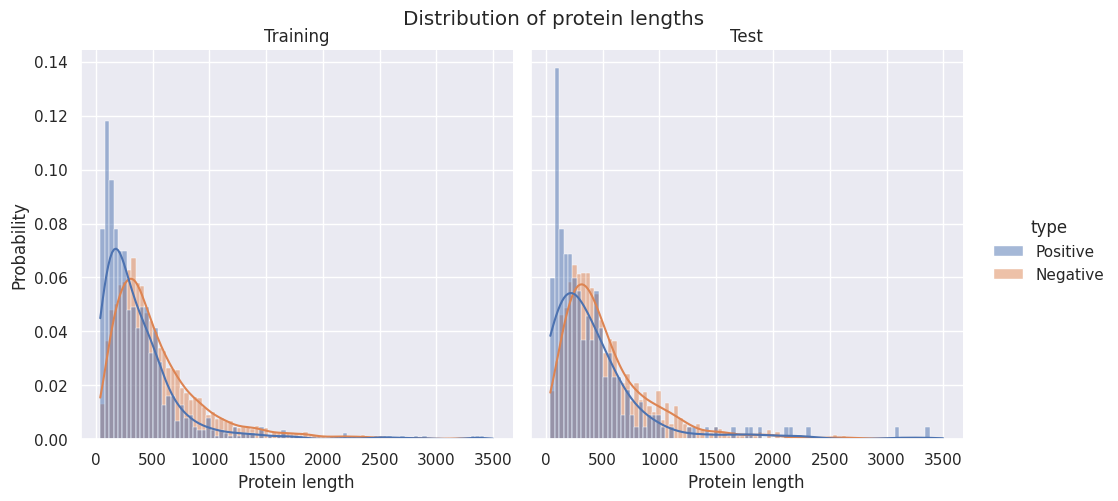

In [28]:
tot_filtered = tot.query('protein_length < 3500')
pl_hist = sns.displot(tot_filtered,x="protein_length",hue="type", col="dataset_class", kind="hist", stat="probability", common_norm=False, kde=True)
pl_hist.fig.suptitle('Distribution of protein lengths', y=1)
pl_hist.set_titles("{col_name}")
pl_hist.set_axis_labels("Protein length", "Probability")
pl_hist.savefig("protein_length_hist.png")

#### Distribution of SP lengths
##### Histograms, density or bloxplot

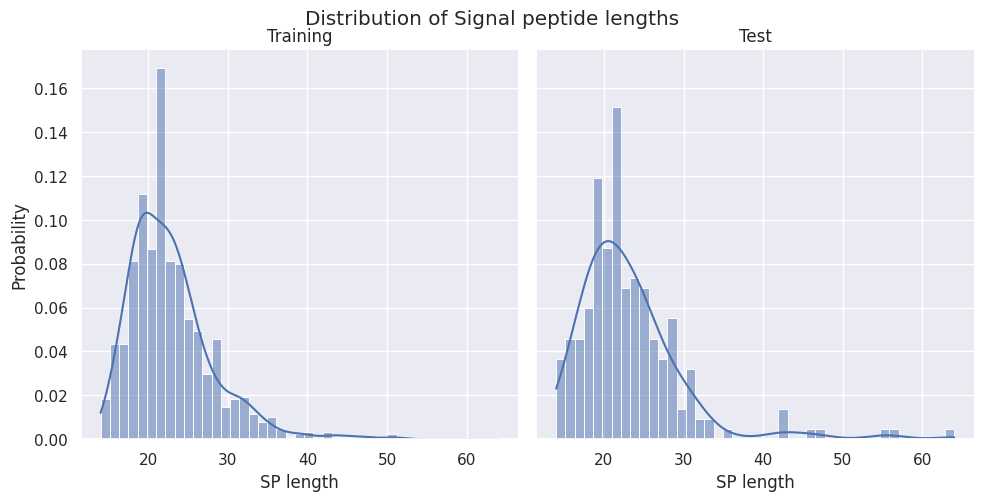

In [29]:
spl_hist = sns.displot(positive,x="pos_cleavage_site",col="dataset_class", kind="hist", stat="probability", common_norm=False, kde=True)
spl_hist.fig.suptitle('Distribution of Signal peptide lengths', y=1)
spl_hist.set_titles("{col_name}")
spl_hist.set_axis_labels("SP length", "Probability")
spl_hist.savefig("SP_length_hist.png")

#### Comparative amino-acid composition of SPs against some background distribution
##### Display AA compositions of SP sequences and SwissProt using a combined barplot

In [30]:
def aminodist(fasta_file, df):
  amino_count = {}
  with open(fasta_file,"r") as file:
    header = True
    presence = False
    for line in file:
      if header == True:
        ID = line.split("\n")[0][1:-1]
        if ID in df.index:
          presence = True
          header = False
          continue
        else:
          presence = False
          header = True
      if header == False:
        if presence == True:
          row = df.loc[ID]
          for seq_index in range(0,int(row["pos_cleavage_site"])-1,1):
            if line[seq_index] in amino_count:
              amino_count[line[seq_index]] += 1
            else:
              amino_count[line[seq_index]] = 1
          header = True
        else:
          header = True
          continue


  amino_count.pop("X",None) #Deleting the X value aminoacids
  total_amino_count = sum(amino_count.values())
  for key in amino_count:
    amino_count[key] = round(((amino_count[key]/total_amino_count)*100),2)
  return amino_count


fasta_file_name = "cluster-results_positive_rep_seq.fasta"


positive_training = positive.query('dataset_class == "Training"')
positive_test = positive.query('dataset_class == "Test"')

amino_distribution_training = aminodist(fasta_file_name,positive_training)
amino_distribution_test = aminodist(fasta_file_name,positive_test)


amino_distribution_training = pd.DataFrame(amino_distribution_training, index=["Training"])
amino_distribution_test = pd.DataFrame(amino_distribution_test, index=["Test"])
reference = {
    "A": 8.25,
    "Q": 3.93,
    "L": 9.64,
    "S": 6.65,
    "R": 5.52,
    "E": 6.71,
    "K": 5.79,
    "T": 5.36,
    "N": 4.06,
    "G": 7.07,
    "M": 2.41,
    "W": 1.10,
    "D": 5.46,
    "H": 2.27,
    "F": 3.86,
    "Y": 2.92,
    "C": 1.38,
    "I": 5.90,
    "P": 4.74,
    "V": 6.85
}
amino_distribution_reference = pd.DataFrame(reference, index=["Reference"])
amino_distribution = pd.concat([amino_distribution_training, amino_distribution_test,amino_distribution_reference])




amino_distribution_long = amino_distribution.reset_index(names='Set').melt(id_vars='Set', var_name='aa', value_name='Percentage')
amino_distribution_long.head(20)

,Set,aa,Percentage
0,Training,M,6.62
1,Test,M,6.53
2,Reference,M,2.41
3,Training,E,1.42
4,Test,E,1.16
5,Reference,E,6.71
6,Training,S,7.41
7,Test,S,7.03
8,Reference,S,6.65
9,Training,R,3.32


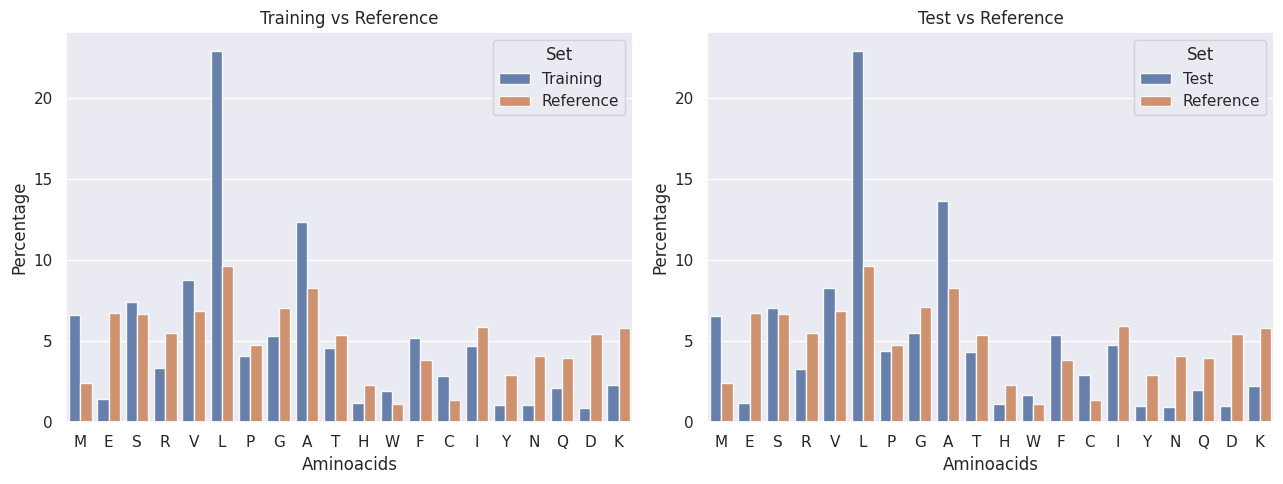

In [31]:
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
sns.barplot(data=amino_distribution_long[amino_distribution_long["Set"].isin(["Training","Reference"])],
            x="aa",
            y="Percentage",
            hue="Set",
            edgecolor="white",
            alpha=0.9).set(
                title = "Training vs Reference",
                xlabel = "Aminoacids"
            )

plt.subplot(1, 2, 2)
sns.barplot(data=amino_distribution_long[amino_distribution_long["Set"].isin(["Test","Reference"])],
            x="aa",
            y="Percentage",
            hue="Set",
            edgecolor="white",
            alpha=0.9).set(
                title = "Test vs Reference",
                xlabel = "Aminoacids"
            )

plt.tight_layout()  # Migliora la spaziatura
plt.show()

#### Taxonomic classification
##### Pie chart or a barplot

In [32]:
# import data
training_kingdom = training['kingdom'].value_counts()
test_kingdom = test['kingdom'].value_counts()
training_species = training['organism_name'].value_counts()
test_species = test['organism_name'].value_counts()
k_colors = sns.color_palette("pastel", len(training_kingdom))
s_colors = sns.color_palette("pastel", len(training_species))

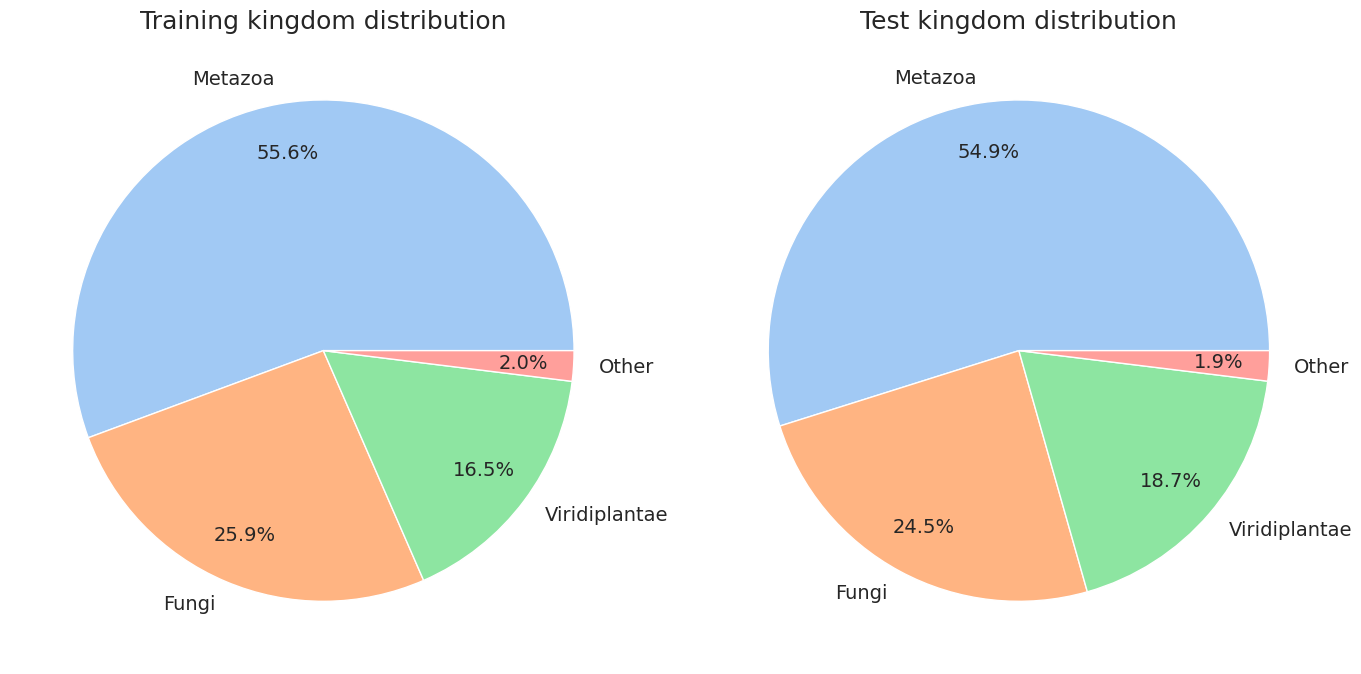

In [33]:
# filter kingdom data
def filter_kingdom(kingdom):
  kingdom_top = kingdom.head(3)
  k_other_sum = kingdom.iloc[3:].sum()
  k_other_series = pd.Series({"Other": k_other_sum})
  kingdom_grouped = pd.concat([kingdom_top, k_other_series])
  return kingdom_grouped
training_k_grouped = filter_kingdom(training_kingdom)
test_k_grouped = filter_kingdom(test_kingdom)

# kingdom piecharts
kingdom_fig, (kingdom_ax1, kingdom_ax2) = plt.subplots(1,2, figsize=(14, 7))
kingdom_ax1.pie(
    training_k_grouped.values,
    labels=training_k_grouped.index,
    autopct='%1.1f%%',
    colors=k_colors,
    textprops={'fontsize': 14},
    pctdistance=0.8,
)
kingdom_ax1.set_title("Training kingdom distribution", fontsize=18)

kingdom_ax2.pie(
    test_k_grouped.values,
    labels=test_k_grouped.index,
    autopct='%1.1f%%',
    colors=k_colors,
    textprops={'fontsize': 14},
    pctdistance=0.8,
)
kingdom_ax2.set_title("Test kingdom distribution", fontsize=18)

kingdom_fig.tight_layout()
kingdom_fig.savefig("kingdom_piechart.png")


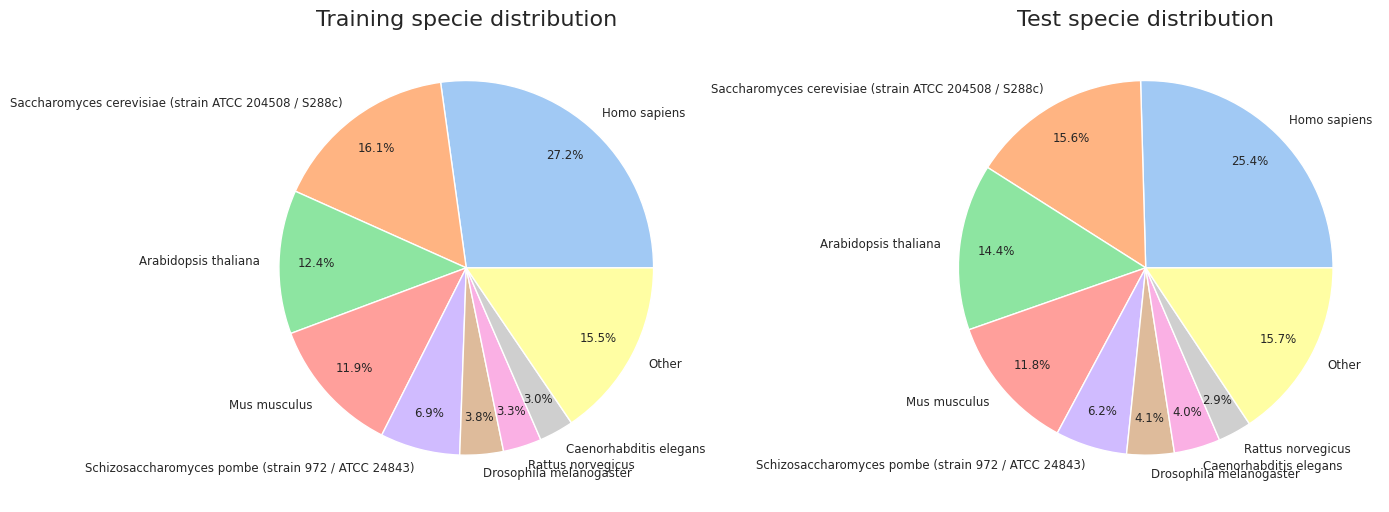

In [36]:
# filter species data
def filter_species(species):
  species_top = species.head(8)
  s_other_sum = species.iloc[8:].sum()
  s_other_series = pd.Series({"Other": s_other_sum})
  species_grouped = pd.concat([species_top, s_other_series])
  return species_grouped
training_s_grouped = filter_species(training_species)
test_s_grouped = filter_species(test_species)

# species piecharts
specie_fig, (specie_ax1, specie_ax2) = plt.subplots(1,2, figsize=(14, 7))
specie_ax1.pie(
    training_s_grouped.values,
    labels=training_s_grouped.index,
    autopct='%1.1f%%',
    colors=s_colors,
    textprops={'fontsize': 8.5},
    pctdistance=0.8
)
specie_ax1.set_title("Training specie distribution", fontsize=16)

specie_ax2.pie(
    test_s_grouped.values,
    labels=test_s_grouped.index,
    autopct='%1.1f%%',
    colors=s_colors,
    textprops={'fontsize': 8.5},
    pctdistance=0.8,
)
specie_ax2.set_title("Test specie distribution", fontsize=16)

specie_fig.tight_layout()
specie_fig.savefig("species_piechart.png")


#### Sequence logos of SP cleavage sites
##### Extract the cleavage-site motifs [-13,+2] and use WebLogo to produce the sequence logo

In [39]:
def motif(fasta_file, df, output):
  with open(output,"w") as output:
    with open(fasta_file,"r") as file:
      header = True
      for line in file:
        if header == True:
          ID = line.split()[0][1:]
          header = False
          continue
        if header == False:
          row = df.loc[ID]
          #print(line[0])
          start = (int(row["pos_cleavage_site"]-13))
          stop = (int(row["pos_cleavage_site"])+2)
          print(f">{ID}",file=output)
          print(f"{line[start:stop]}",file = output)
          header = True
  return

motif(fasta_file_name,positive,"motif_alignment.fasta")
